<a href="https://colab.research.google.com/github/mswerdloffNU/na-erdos-fellows-monorepo/blob/oceanoptimizers%2FXGBoost_Phytoplankton/XGBoost_Phytoplankton_10fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SHAP plot/feature intrepertation, so wanted to share my fav resource on SHAP and how to intrpetet it's outputs/viz:
https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-d4d2c95ce63b>:15: DtypeWarning: Columns (0,1,3,6,7,8,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


RMSE: 0.08976606573157365
R²: 0.9976034910819388


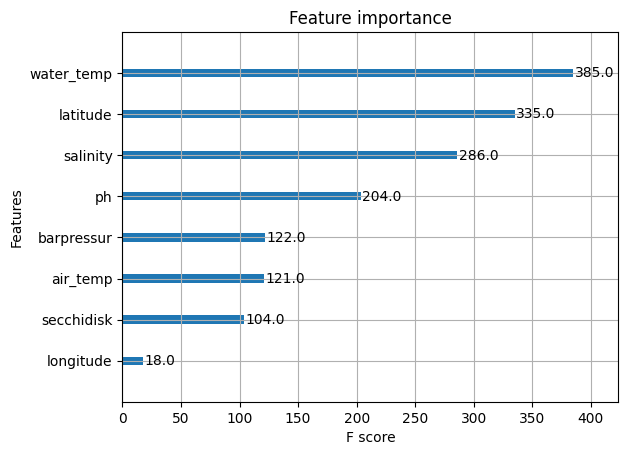

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best RMSE: 0.09429011121029718
Best R²: 0.9973558446780718


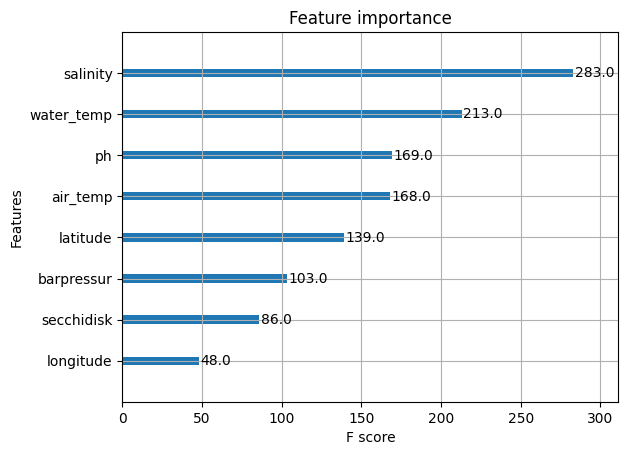

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/NAL Project/bedi_PMN_a8c8_33ad_9eab.csv'  # Update the path if your file is in a different location
data = pd.read_csv(file_path)

# Remove the first row (metadata)
data = data.iloc[1:]

# Convert relevant columns to numeric types
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')
data['water_temp'] = pd.to_numeric(data['water_temp'], errors='coerce')
data['air_temp'] = pd.to_numeric(data['air_temp'], errors='coerce')
data['salinity'] = pd.to_numeric(data['salinity'], errors='coerce')
data['ph'] = pd.to_numeric(data['ph'], errors='coerce')
data['dissoxygen'] = pd.to_numeric(data['dissoxygen'], errors='coerce')
data['secchidisk'] = pd.to_numeric(data['secchidisk'], errors='coerce')
data['barpressur'] = pd.to_numeric(data['barpressur'], errors='coerce')

# Drop rows with missing target variable 'dissoxygen'
data = data.dropna(subset=['dissoxygen'])

# Drop remaining rows with any missing values
data = data.dropna()

# Select relevant features and target variable
X = data[['latitude', 'longitude', 'water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']]
y = data['dissoxygen']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Plot feature importance
xgb.plot_importance(model)
plt.show()

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_model.fit(X_train, y_train)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Calculate evaluation metrics for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f'Best RMSE: {rmse_best}')
print(f'Best R²: {r2_best}')

# Plot feature importance for the best model
xgb.plot_importance(best_model)
plt.show()


The output shows the feature importance plots and the evaluation metrics for the XGBoost models, both before and after hyperparameter tuning.

### Interpretation of the Results

1. **Evaluation Metrics**:
   - **RMSE (Root Mean Squared Error)**:
     - Initial Model: 0.08976606573157365
     - Best Model: 0.09429011121029718
   - **R² (Coefficient of Determination)**:
     - Initial Model: 0.9976034910819388
     - Best Model: 0.9973558446780718

The RMSE values are very low, and the R² values are very high (close to 1). The high R² values likely indicates there may be some overfitting. The small difference between the initial and best models suggests that the initial hyperparameters were already quite good.

2. **Feature Importance**:
   - **Initial Model**:
     - Most important features: Water temperature, latitude, salinity, pH
   - **Best Model**:
     - Most important features: Salinity, water temperature, pH, air temperature

The feature importance plots indicate which variables had the most influence on predicting the dissolved oxygen levels. In both models, water temperature and salinity are among the most important features.

### Summary
- Both models perform well, with very low RMSE and very high R². We can better understand the RMSE result if we take it into context of the units of measurment and what is an acceptable margin of error when it comes to oxygen levels.
- Water temperature and salinity are consistently important features. The learning rate changing from 0.1 to 0.2 might have been to large, which could have impacted why the order of importance changed. The higher learning rate may have destabilized the model.
- Hyperparameter tuning slightly adjusted the importance of features but did not significantly change the model's performance. The importance of the features may be changing due to overfitting.



Detailed Evaluation of Model Performance
Cross-Validation: Perform k-fold cross-validation to ensure the model's robustness and reliability.
Residual Analysis: Analyze the residuals (differences between actual and predicted values) to check for any patterns indicating model issues.
Error Analysis: Identify cases where the model performs poorly and investigate why.

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f'Cross-validated RMSE scores: {cv_rmse}')
print(f'Mean cross-validated RMSE: {cv_rmse.mean()}')


Cross-validated RMSE scores: [3.73482788 1.17495173 0.87208269 0.82233621 2.69879496 0.40404557
 0.12599354 1.17083577 1.22524681 2.12720225]
Mean cross-validated RMSE: 1.4356317398752594


The cross-validated RMSE scores show variability across the different folds, with an average RMSE of approximately 1.44. This suggests that while the model performs well on average, there is some inconsistency across the different subsets of the data. This suggests that it was overfitting.

In [ ]:
# Import KFold from sklearn.model_selection
from sklearn.model_selection import KFold

# Perform 3-fold cross-validation and compute RMSE and R² for each fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = best_model.predict(X_test_fold)

    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')

Fold 1 - RMSE: 0.0028210620238077653, R²: 0.9999978401886849
Fold 2 - RMSE: 0.0011205314128628345, R²: 0.999999580696327
Fold 3 - RMSE: 0.3055792354085618, R²: 0.954831652096518
Fold 4 - RMSE: 0.0014686652650603381, R²: 0.9999994191205002
Fold 5 - RMSE: 0.20381630086100463, R²: 0.9874491643159777
Fold 6 - RMSE: 0.0016730909897673767, R²: 0.9999993012580806
Fold 7 - RMSE: 0.0012698148376401486, R²: 0.9999992708191364
Fold 8 - RMSE: 0.0015002819004034129, R²: 0.9999992303749143
Fold 9 - RMSE: 0.0015998509543668459, R²: 0.9999984777374032
Fold 10 - RMSE: 0.001836018340692147, R²: 0.9999990780549383
Mean RMSE: 0.05226848519941674, Mean R²: 0.9942273014662479


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best RMSE: 0.09263701715290183
Best R²: 0.9974477465940544


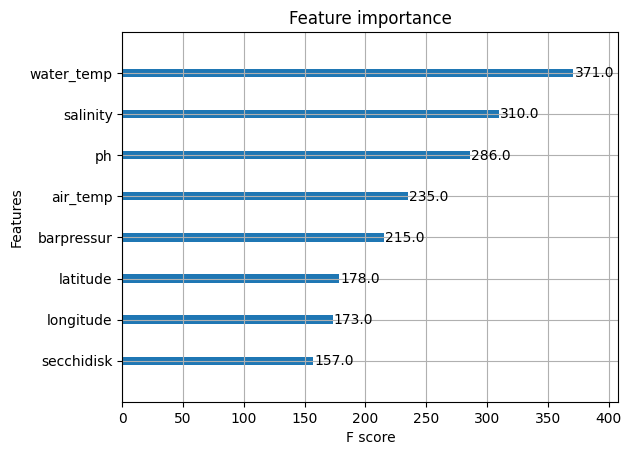

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=10, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_model.fit(X_train, y_train)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Calculate evaluation metrics for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f'Best RMSE: {rmse_best}')
print(f'Best R²: {r2_best}')

# Plot feature importance for the best model
xgb.plot_importance(best_model)
plt.show()

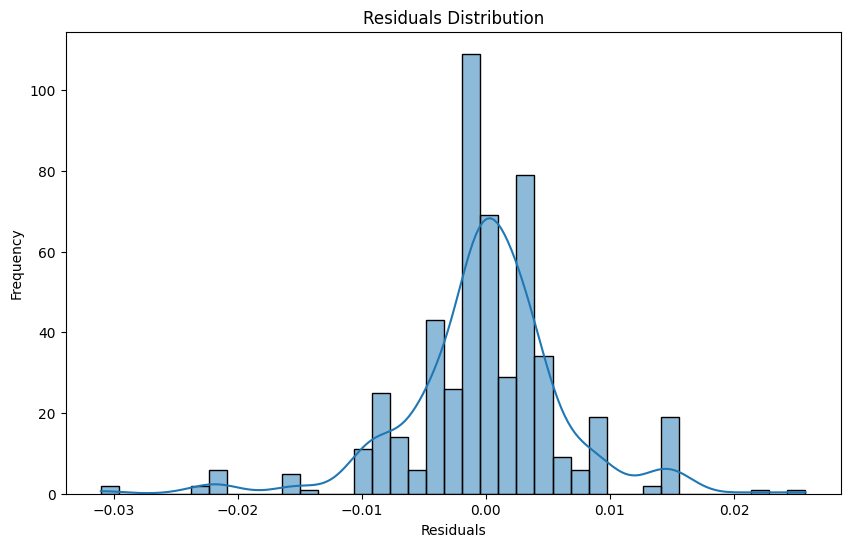

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the training set
y_train_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


The residuals distribution plot shows that most residuals are centered around zero, which is a good sign. The residuals appear to be symmetrically distributed with some minor skewness, indicating that the model's errors are reasonably well-behaved.

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.7 MB/s eta 0:00:00


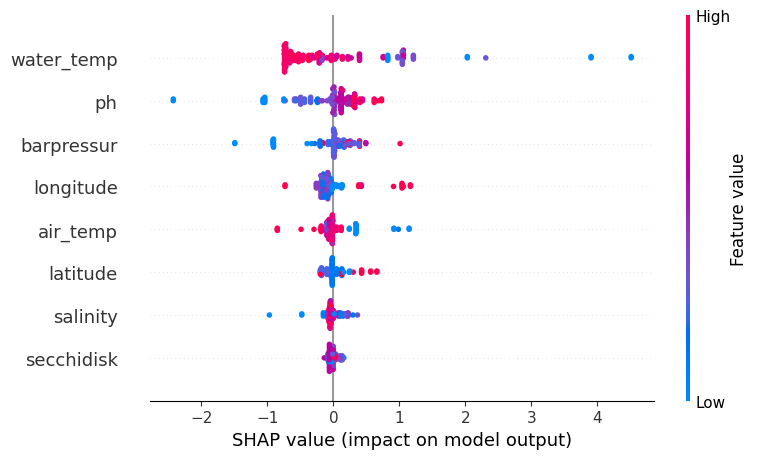

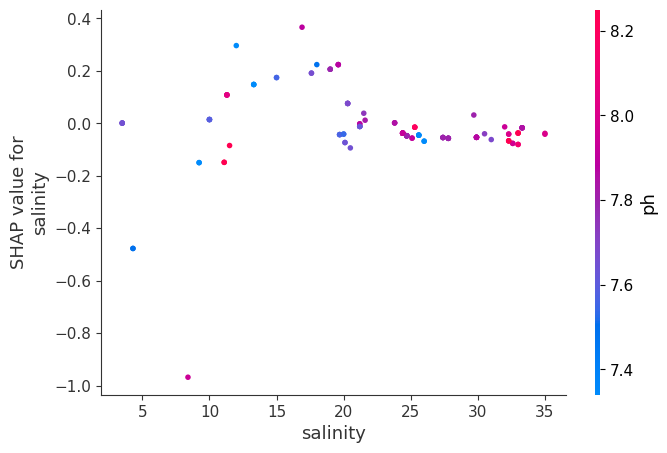

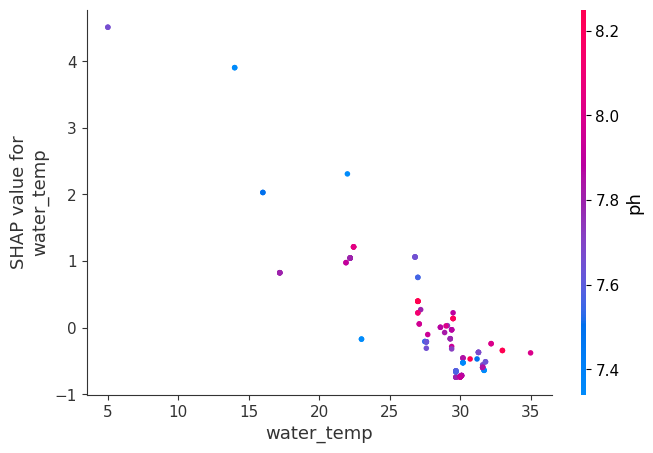

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


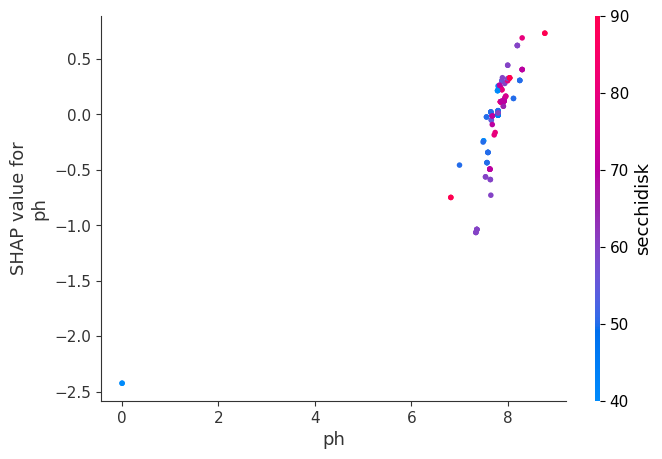

In [ ]:
# SHAP Analysis without interaction terms
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test)

# Plot the SHAP dependency plots for important features
for feature in ['salinity', 'water_temp', 'ph']:
    shap.dependence_plot(feature, shap_values, X_test)

In [ ]:
# Example of creating interaction terms
X_int = X.copy()  # Ensure we are working on a copy of the dataframe
X_int['temp_salinity_interaction'] = X_int['water_temp'] * X_int['salinity']

# Update your train-test split and model training steps
X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.2, random_state=42)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best RMSE: 0.09568739818209149
Best R²: 0.9972768964355976


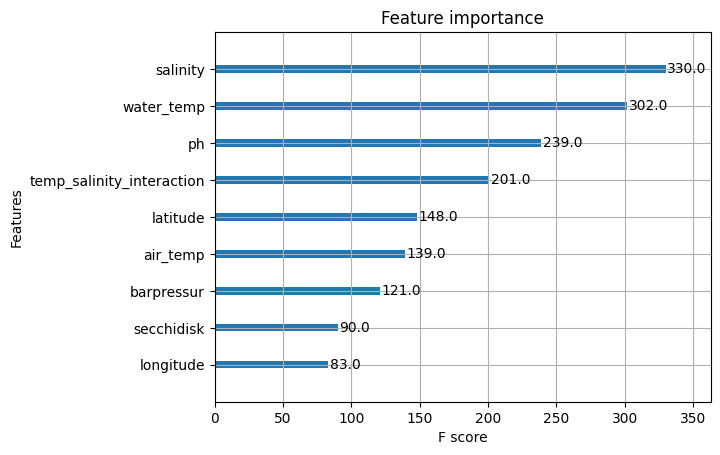

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=10, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_model.fit(X_train, y_train)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Calculate evaluation metrics for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f'Best RMSE: {rmse_best}')
print(f'Best R²: {r2_best}')

# Plot feature importance for the best model
xgb.plot_importance(best_model)
plt.show()


The cross-validation results indicate that the final model was still quite good for the best of the 3 cv-splits. We should look at the RMSE's from all 3 cv-splits to confirm that it wasn't just a fluke. If they are all similar to the best, then it would indicate that there is the potential for a deep learning model to achieve near perfect results. We should also compare the feature importances from the XGBoost to the dependency plots from a SHAP model before moving forward with the deep learning model.

In [ ]:
# Import KFold from sklearn.model_selection
from sklearn.model_selection import KFold

# Perform 10-fold cross-validation and compute RMSE and R² for each fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_int):
    X_train_fold, X_test_fold = X_int.iloc[train_index], X_int.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = best_model.predict(X_test_fold)

    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')

Fold 1 - RMSE: 0.0005344209673342852, R²: 0.9999999224900387
Fold 2 - RMSE: 0.00025587045805332606, R²: 0.9999999781364395
Fold 3 - RMSE: 0.18041242227677956, R²: 0.9842558433884578
Fold 4 - RMSE: 0.0006251547942297401, R²: 0.9999998947515921
Fold 5 - RMSE: 0.23384805628425617, R²: 0.9834780104769776
Fold 6 - RMSE: 0.0015717271073733842, R²: 0.9999993833596141
Fold 7 - RMSE: 0.0001429918033078665, R²: 0.9999999907535132
Fold 8 - RMSE: 0.0002743110203044342, R²: 0.999999974271173
Fold 9 - RMSE: 0.0004479805252594022, R²: 0.9999998806427521
Fold 10 - RMSE: 0.0003094753602994087, R²: 0.999999973805919
Mean RMSE: 0.04184224105971976, Mean R²: 0.9967732852076476


The RMSE and R² values vary significantly across the three folds. Fold 3 shows an exceptionally low RMSE and almost perfect R², while Folds 1 and 2 have higher RMSE values and lower R² values.

This variation suggests that the model's performance is not consistent across different data splits. The very low RMSE and high R² in Fold 3 might be due to the specific characteristics of the data in that fold, possibly indicating an easier-to-predict subset of the data.

The low RMSE and high R² values, especially in the best-performing fold, indicate that there is potential for a more complex model (e.g., a deep learning model) to achieve near-perfect results.

Before moving forward with a deep learning model, it's essential to confirm that the high performance is not just a fluke by ensuring that all folds show similar performance metric.

**Feature Importances and SHAP Values:**
Comparing the feature importances from the XGBoost model to the dependency plots from a SHAP model can provide insights into which features are most influential in predicting the target variable.
This comparison helps in understanding the model's behavior and ensuring that the model's predictions are based on meaningful relationships in the data.

In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.6 MB/s eta 0:00:00


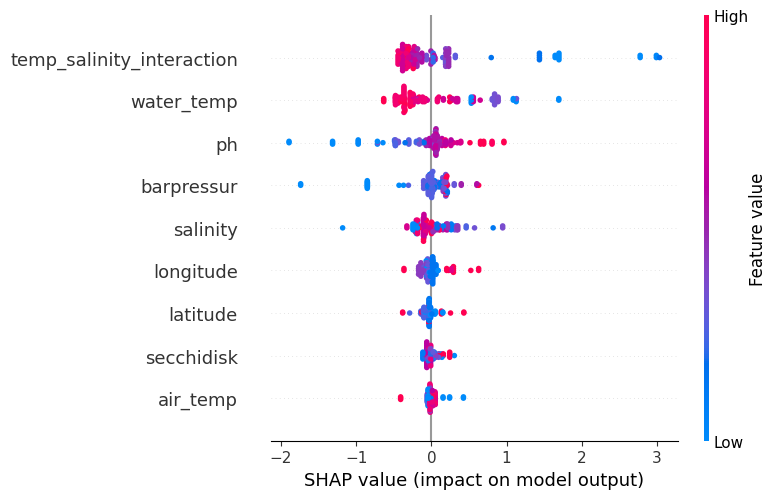

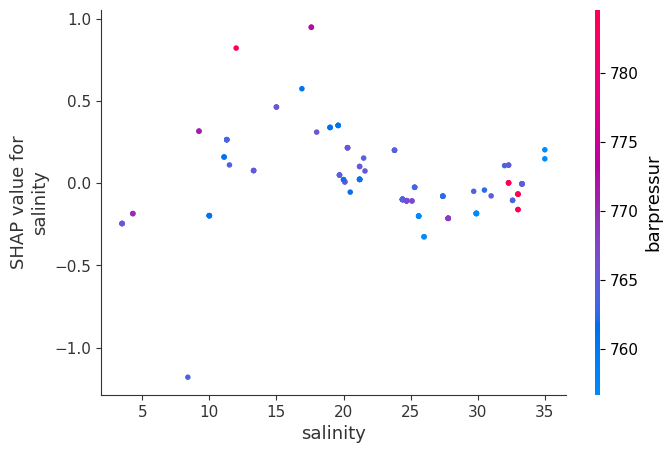

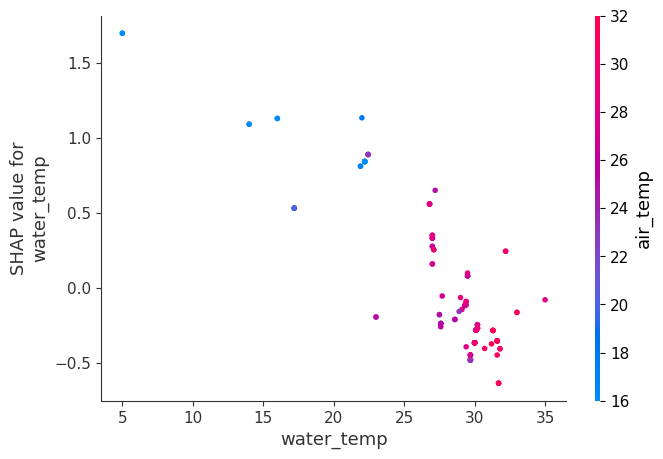

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


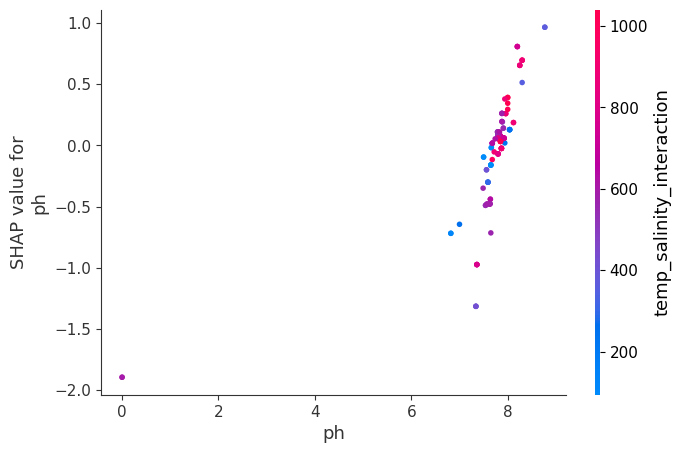

In [ ]:
import shap

# SHAP Analysis
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test)

# Plot the SHAP dependency plots for important features
for feature in ['salinity', 'water_temp', 'ph']:
    shap.dependence_plot(feature, shap_values, X_test)

Figure 1 : Water Temperature: The most influential feature. Higher water temperatures have both positive and negative impacts on the model output, suggesting a complex relationship with the target variable.
Temp_Salinity_Interaction: Interaction term between temperature and salinity also plays a significant role, indicating that the combined effect of these two features is important.
pH: Important but less influential than the above two. Generally, higher pH values seem to have a negative impact.
Barometric Pressure: This feature also contributes to the model's predictions.
Latitude and Salinity: These features are moderately important.
Longitude, Secchi Disk, and Air Temperature: These features have lower impacts on the model.


Figure 2:  Salinity
Salinity has a non-linear relationship with the target variable.
The SHAP value generally increases with salinity up to a certain point before stabilizing.
Higher salinity levels positively impact the model output, indicating better oxygen levels.


Figure 3: Water Temperature
Higher water temperatures have a varied impact.
For some ranges, higher temperatures are associated with higher SHAP values (positive impact), while for others, it’s negative.
Indicates that temperature impacts oxygen levels differently depending on other conditions.

Figure 4: pH
pH values have a mostly negative SHAP value.
Lower pH values tend to have a more negative impact.
Higher pH values are associated with better oxygen levels.


**Conclusion and Next Steps**


**Feature Importance:** Water temperature, the interaction of temperature and salinity, and pH are the most important features affecting oxygen levels.
Complex Relationships: The relationship between these features and oxygen levels is complex and non-linear, suggesting that simple linear models may not capture the true dynamics.

**Deep Learning Model:** Given the complex interactions, a deep learning model may further improve predictions.
Validation: Validate these findings with additional data or cross-validation to ensure robustness.

**Domain Expertise:** Consult with marine biologists to interpret these findings in a real-world context.


In [ ]:
import pandas as pd
import numpy as np

# Example of creating a new data fetching function (simulated)
def get_real_time_data():
    # Simulate fetching real-time data
    # In practice, this function would pull data from a live data source
    new_data = pd.DataFrame({
        'latitude': [30.0],
        'longitude': [-80.0],
        'water_temp': [22.0],
        'air_temp': [25.0],
        'salinity': [35.0],
        'ph': [8.1],
        'secchidisk': [10.0],
        'barpressur': [1013.0]
    })
    return new_data

# Example of setting up a real-time prediction pipeline
def preprocess_new_data(new_data):
    # Implement preprocessing steps similar to the training data
    new_data['temp_salinity_interaction'] = new_data['water_temp'] * new_data['salinity']
    # Ensure all features are present and in the correct format
    return new_data

def real_time_prediction(new_data):
    new_data_preprocessed = preprocess_new_data(new_data)  # Implement preprocessing
    prediction = best_model.predict(new_data_preprocessed)
    return prediction

# Use the function with new real-time data
new_data = get_real_time_data()  # Fetch or simulate new data
oxygen_prediction = real_time_prediction(new_data)
print(f'Real-time oxygen level prediction: {oxygen_prediction}')


Real-time oxygen level prediction: [6.0065928]
